In [80]:
import cv2 

img = cv2.imread('Flowers/Cempa/1.jpg')
print(img.shape[0], img.shape[1], img.shape[2], len(img.shape))

200 200 3 3


# Convolutional Neural Networks

# Importar Librerías

In [81]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [82]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Conv2D
)
from keras.layers import LeakyReLU

# Cargar set de Imágenes

In [83]:
dirname = os.path.join(os.getcwd(),'Flowers/')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
            if(len(image.shape)==3):
                
                images.append(image)
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

leyendo imagenes de  c:\Users\betov\OneDrive\Documentos\ITM\9no Semestre\Inteligencia Artificial\Repositorio\InteligenciaArtificial\Proyecto 1.- Clasificador\Flowers/\
c:\Users\betov\OneDrive\Documentos\ITM\9no Semestre\Inteligencia Artificial\Repositorio\InteligenciaArtificial\Proyecto 1.- Clasificador\Flowers/\Cempa 1
c:\Users\betov\OneDrive\Documentos\ITM\9no Semestre\Inteligencia Artificial\Repositorio\InteligenciaArtificial\Proyecto 1.- Clasificador\Flowers/\Dandelion 7782
c:\Users\betov\OneDrive\Documentos\ITM\9no Semestre\Inteligencia Artificial\Repositorio\InteligenciaArtificial\Proyecto 1.- Clasificador\Flowers/\Girasol 8151
c:\Users\betov\OneDrive\Documentos\ITM\9no Semestre\Inteligencia Artificial\Repositorio\InteligenciaArtificial\Proyecto 1.- Clasificador\Flowers/\Orquidea 7659
c:\Users\betov\OneDrive\Documentos\ITM\9no Semestre\Inteligencia Artificial\Repositorio\InteligenciaArtificial\Proyecto 1.- Clasificador\Flowers/\Rosa 7622
Directorios leidos: 5
Imagenes en cada dir

# Creamos las etiquetas

In [84]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))


Cantidad etiquetas creadas:  39214


In [85]:
flores=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    flores.append(name[len(name)-1])
    indice=indice+1

0 Cempa
1 Dandelion
2 Girasol
3 Orquidea
4 Rosa


In [86]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy



# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  5
Output classes :  [0 1 2 3 4]


# Creamos Sets de Entrenamiento y Test

In [87]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (31371, 200, 200, 3) (31371,)
Testing data shape :  (7843, 200, 200, 3) (7843,)


Text(0.5, 1.0, 'Ground Truth : 1')

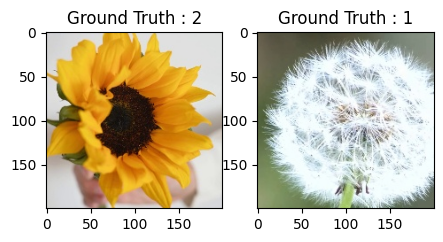

In [88]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

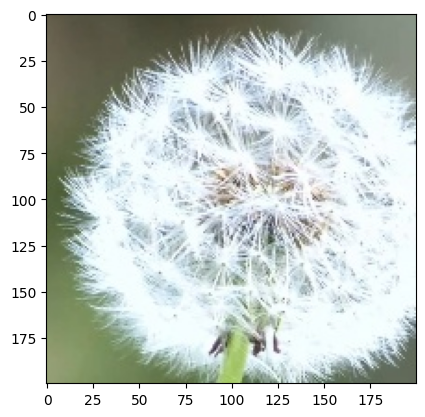

In [89]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X/255.
test_X = test_X/255.
plt.imshow(test_X[0,:,:])

## Hacemos el One-hot Encoding para la red

In [90]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 2
After conversion to one-hot: [0. 0. 1. 0. 0.]


# Creamos el Set de Entrenamiento y Validación

In [91]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [92]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(25096, 200, 200, 3) (6275, 200, 200, 3) (25096, 5) (6275, 5)


# Creamos el modelo de CNN

In [93]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 20 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
# batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria
batch_size = 32 # cantidad de imágenes que se toman a la vez en memoria

In [94]:
Flower_model = Sequential()
#Flower_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(21,28,3)))
Flower_model.add(Conv2D(32, kernel_size=(3, 3), activation='linear', padding='same', input_shape=(200, 200, 3)))

Flower_model.add(LeakyReLU(alpha=0.1))
Flower_model.add(MaxPooling2D((2, 2),padding='same'))
Flower_model.add(Dropout(0.5))

Flower_model.add(Flatten())
Flower_model.add(Dense(32, activation='linear'))
Flower_model.add(LeakyReLU(alpha=0.1))
Flower_model.add(Dropout(0.5))
Flower_model.add(Dense(nClasses, activation='softmax'))

In [95]:
Flower_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      896       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 200, 200, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 100, 100, 32)      0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 100, 100, 32)      0         
                                                                 
 flatten_1 (Flatten)         (None, 320000)            0         
                                                                 
 dense_2 (Dense)             (None, 32)                10240032  
                                                      

In [96]:
Flower_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=INIT_LR, decay=INIT_LR / 100),metrics=['accuracy'])

# Entrenamos el modelo: Aprende a clasificar imágenes

In [97]:
# este paso puede tomar varios minutos, dependiendo de tu ordenador, cpu y memoria ram libre
Flower_train = Flower_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/20
785/785 [==============================] - 180s 226ms/step - loss: 0.6014 - accuracy: 0.8055 - val_loss: 0.2078 - val_accuracy: 0.9508
Epoch 2/20
785/785 [==============================] - 159s 203ms/step - loss: 0.2577 - accuracy: 0.9283 - val_loss: 0.0792 - val_accuracy: 0.9841
Epoch 3/20
785/785 [==============================] - 157s 200ms/step - loss: 0.1701 - accuracy: 0.9512 - val_loss: 0.0469 - val_accuracy: 0.9912
Epoch 4/20
785/785 [==============================] - 155s 198ms/step - loss: 0.1263 - accuracy: 0.9653 - val_loss: 0.0281 - val_accuracy: 0.9979
Epoch 5/20
785/785 [==============================] - 155s 198ms/step - loss: 0.1039 - accuracy: 0.9710 - val_loss: 0.0230 - val_accuracy: 0.9976
Epoch 6/20
785/785 [==============================] - 154s 196ms/step - loss: 0.0891 - accuracy: 0.9743 - val_loss: 0.0178 - val_accuracy: 0.9994
Epoch 7/20
785/785 [==============================] - 158s 201ms/step - loss: 0.0722 - accuracy: 0.9808 - val_loss: 0.0118 -

In [98]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
Flower_model.save("celulas.h5py")

INFO:tensorflow:Assets written to: celulas.h5py\assets


INFO:tensorflow:Assets written to: celulas.h5py\assets


# Evaluamos la red

In [99]:
test_eval = Flower_model.evaluate(test_X, test_Y_one_hot, verbose=1)

246/246 [==============================] - 9s 36ms/step - loss: 0.0087 - accuracy: 0.9994


In [100]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.008725391700863838
Test accuracy: 0.9993624687194824


In [101]:
Flower_train.history

{'loss': [0.6013968586921692,
  0.25765517354011536,
  0.1700526773929596,
  0.12634475529193878,
  0.10390299558639526,
  0.08908063173294067,
  0.07215616852045059,
  0.06454760581254959,
  0.058624155819416046,
  0.05345731973648071,
  0.046991534531116486,
  0.04663289338350296,
  0.04304784536361694,
  0.04013203829526901,
  0.037495892494916916,
  0.0355832464993,
  0.03399902209639549,
  0.03170333802700043,
  0.031000250950455666,
  0.029284264892339706],
 'accuracy': [0.8055068254470825,
  0.928315281867981,
  0.9512273073196411,
  0.9652534127235413,
  0.9709515571594238,
  0.9742588400840759,
  0.9807937741279602,
  0.9825071692466736,
  0.9844596982002258,
  0.9858144521713257,
  0.9883248209953308,
  0.9878864884376526,
  0.9892014861106873,
  0.990317165851593,
  0.9899585843086243,
  0.9903570413589478,
  0.9913133382797241,
  0.9921501278877258,
  0.992588460445404,
  0.9934650659561157],
 'val_loss': [0.2078222632408142,
  0.07922539114952087,
  0.04694404453039169,
  

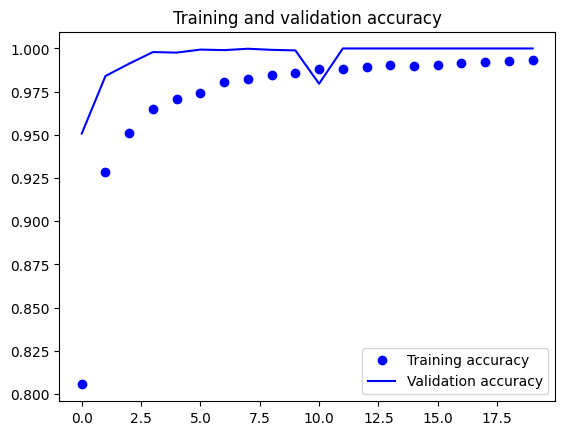

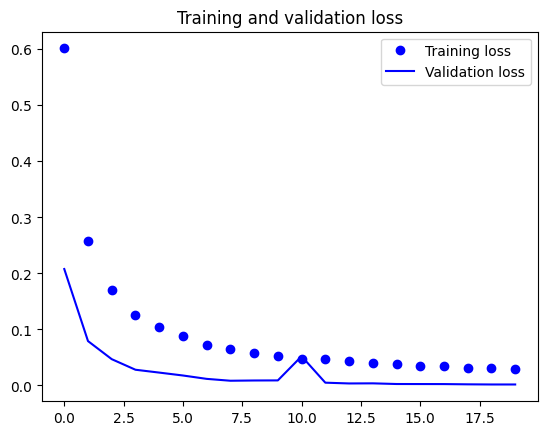

In [102]:
accuracy = Flower_train.history['accuracy']
val_accuracy = Flower_train.history['val_accuracy']
loss = Flower_train.history['loss']
val_loss = Flower_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [103]:
predicted_classes2 = Flower_model.predict(test_X)

246/246 [==============================] - 9s 35ms/step


In [104]:
predicted_classes=[]
for predicted_flower in predicted_classes2:
    predicted_classes.append(predicted_flower.tolist().index(max(predicted_flower)))
predicted_classes=np.array(predicted_classes)

In [105]:
predicted_classes.shape, test_Y.shape

((7843,), (7843,))

# Aprendamos de los errores: Qué mejorar

Found 7838 correct labels


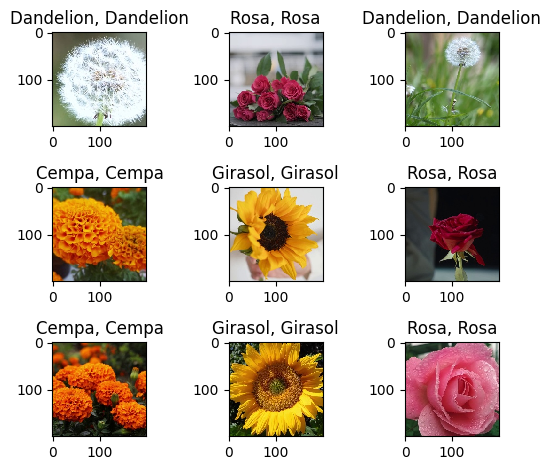

In [106]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(200,200,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(flores[predicted_classes[correct]],
                                                    flores[test_Y[correct]]))

    plt.tight_layout()

Found 5 incorrect labels


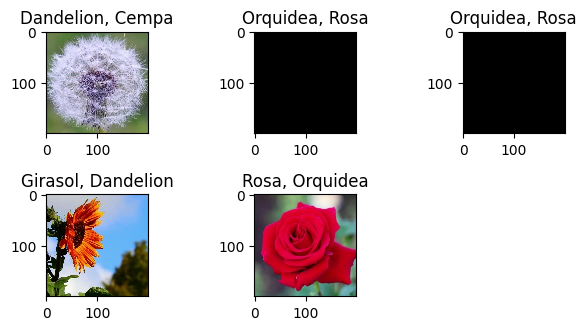

In [107]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(200,200,3), cmap='gray', interpolation='none')
    plt.title("{}, {}".format(flores[predicted_classes[incorrect]],
                                                    flores[test_Y[incorrect]]))
    plt.tight_layout()

In [108]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      1559
     Class 1       1.00      1.00      1.00      1632
     Class 2       1.00      1.00      1.00      1522
     Class 3       1.00      1.00      1.00      1489
     Class 4       1.00      1.00      1.00      1641

    accuracy                           1.00      7843
   macro avg       1.00      1.00      1.00      7843
weighted avg       1.00      1.00      1.00      7843

